* Improve bankruptcy model using gradient boosting
* Evaluate Model using precision and recall
* Create an interactive dashboard
* Create a python module to store the prediction function

In [26]:
# Import Libraries
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from teaching_tools.widgets import ConfusionMatrixWidget


# Prepare Data

## Import

In [3]:
def wrangle(filename):
     # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)
     
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df

In [4]:
df = wrangle("poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


# Split

In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [6]:
# Divide into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


# Resample

In [11]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model
First I'll calculate the baseline accuracy.

## Baseline

In [7]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


# Iterate
Even though the building blocks are the same with the previous notebook, here's where I start working with something new. First, I'm going to use a new type of ensemble model for our classifier.

Ensemble models are machine learning models that use more than one predictor to arrive at a prediction. A group of predictors form an _ensemble_. In general, ensemble models perform better than using a single predictor. There are three types of ensemble models: **bagging**, **boosting**, and **blending**. Of the three, decision trees are commonly used to construct bagging and boosting models.

Gradient boosting trees is another ensemble model. It uses a collection of tree models arranged in a sequence. Here, the model is built stage-wise; each additional tree aims to correct the previous tree's incorrect. 

Where does the name *gradient* in gradient boosting trees come from? Gradient descent is a minimization algorithm that updates/improves the current answer by taking a step in the direction of minimizing the loss function. This is the same as the gradient boosting trees algorithm as it adds trees to minimize loss/improve model performance. The term **boosting** refers to the algorithm's ability to combine multiple weak models in sequence to form a stronger model. 

Gradient boosting trees have a similar set of hyperparameters as random forests but with some key additions.

<table>
	<tr>
    <th style="text-align: left">Hyperparameter</th>
    <th style="text-align: left">Description</th>
	</tr>  
    <tr>
        <td style="text-align: left"><code>learning_rate</code></td>
        <td style="text-align: left">Multiplicative factor of the tree's contribution to the model.</td>
	</tr>
    <tr>
        <td style="text-align: left"><code>subsample</code></td>
        <td style="text-align: left">Fraction of the training data to use when fitting the trees.</td>
	</tr>
</table>

The learning rate determines how much each tree affect the final outcome and is very important in model convergence. Thus it should be considered during hyperparameter tuning to improve model performance.

Next I'll Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `GradientBoostingClassifier` predictor.

In [8]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

I'm doing this because I only want to be to be looking at the positive class. Here, the positive class is the one where the companies really did go bankrupt.

I'll be tuning some of the hyperparameters next

In [9]:
# Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [10]:
# Create a GridSearchCV named model that includes your classifier and hyperparameter grid.
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=1,  verbose=1)

In [12]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [13]:
# Extract the cross-validation results from model and load them into a DataFrame named cv_results.
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,5.785408,0.162590,0.006818,0.001318,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.930240,0.913129,0.913458,0.925962,0.911455,0.918849,0.007705,1
17,5.644468,0.050552,0.007281,0.002567,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.915762,0.897006,0.909181,0.915762,0.911455,0.909833,0.006898,2
14,5.011922,0.101110,0.007421,0.001645,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.916749,0.899638,0.898322,0.909181,0.895655,0.903909,0.007877,3
15,4.992399,0.246169,0.006954,0.000530,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.906219,0.889108,0.895031,0.897993,0.902238,0.898118,0.005888,4
12,4.286886,0.152849,0.007072,0.001104,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.901941,0.888450,0.884501,0.896677,0.872284,0.888771,0.010258,5
13,4.283405,0.217841,0.005722,0.000398,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.892399,0.878578,0.885160,0.879237,0.883476,0.883770,0.004980,6
10,4.601521,0.022702,0.005891,0.000330,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.874630,0.877591,0.869365,0.866074,0.866359,0.870804,0.004580,7
8,3.873693,0.169094,0.005792,0.000454,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.862126,0.864758,0.858506,0.857519,0.855826,0.859747,0.003245,8
11,4.769110,0.170987,0.006729,0.001118,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.863442,0.858506,0.846331,0.862126,0.850889,0.856259,0.006610,9
6,3.198209,0.076996,0.005949,0.000660,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.848634,0.844686,0.847318,0.844357,0.853851,0.847769,0.003438,10


There's quite a few hyperparameters here, so I'll pull out the ones that work best for the model.

In [14]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

# Evaluate

In [15]:
# calculate the training and test accuarcy scores for the model
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)


print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9265
Validation Accuracy: 0.8803


Just like before, I'll  make a confusion matrix to see how the model is making its correct and incorrect predictions.

In [16]:
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

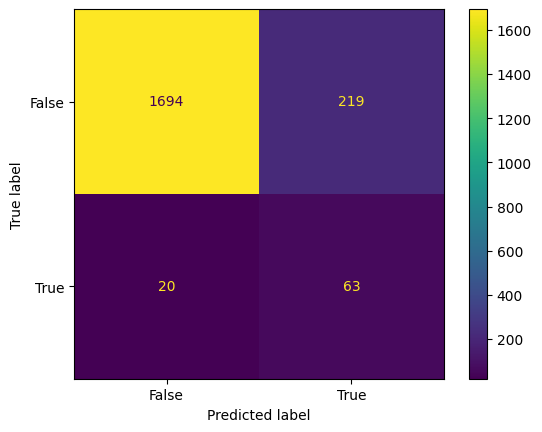

In [17]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

This matrix is a great reminder of how imbalanced the data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in the dataset didn't go bankrupt, all the model has to do is always predict `{"bankrupt": False}`, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, I can evaluate the model using two new metrics: **precision** and **recall**.  The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. The *recall* score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes. 


In [18]:
# Print the classification report for the model, using the test set.
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.89      0.93      1913
        True       0.22      0.76      0.35        83

    accuracy                           0.88      1996
   macro avg       0.61      0.82      0.64      1996
weighted avg       0.96      0.88      0.91      1996



The precision for the false class is 0.99, which means that when the model predicts a company is not bankrupt, it is correct 99% of the time. The recall for the false class is 0.89, which means that when a company is actually not bankrupt, the model correctly identifies it 89% of the time.

The precision for the True class "1" is 0.22, which means that when the model predicts a company is bankrupt, it is correct 22% of the time. The recall for the true class is 0.76, which means that the model identifies 76% of the bankrupt companies correctly.

The F1-score is a weighted harmonic mean of precision and recall. The F1-score for the false class is 0.93, indicating a high level of accuracy, while the F1-score for the true class is 0.35, indicating that the model's performance is relatively poor for this class.

The overall accuracy of the model is 0.88, meaning that it correctly identifies the class of a company 88% of the time. The macro average F1-score is 0.64, which provides a balanced view of the model's performance across both classes. The weighted average F1-score is 0.91, taking into account the fact that the negative class "0" has a much larger number of samples than the positive class.

In [27]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

Next I'll create an interactive dashboard that shows how company profit and losses change in relationship to the model's probability threshold. Starting with the make_cnf_matrix function, which should calculate and print profit/losses, and displaying a confusion matrix. Then I'll create a FloatSlider thresh_widget that ranges from 0 to 1. And then finally I'll combine the function and slider in the interact function.

If you move the probability threshold, you can see that there's a tradeoff between precision and recall. That is, as one gets better, the other suffers. As a data scientist, you'll often need to decide whether you want a model with better precision or better recall. What you choose will depend on how to intend to use your model.

In [37]:
def make_cnf_matrix(threshold):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Profit:  €{tp * 100_000_000}")
    print(f"Losses:  €{tp * 250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False)


thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communicate

In [38]:
# Using a context manager, save the best-performing model to a file named "gradient_boosting.pkl".
with open("gradient_boosting.pkl", "wb") as f:
    pickle.dump(model, f)
